# Analizando los espectros w-k en las CLO

Link: [Colab Notebook](https://colab.research.google.com/drive/1WqKrMgk1bvl1IAm488CHmlJKieWT_teU)

Luego de descargar los espectros del [ftp](ftp://ecco.jpl.nasa.gov/ECCO2/LLC4320/global/spectral_analysis/) y almacenarnos en mi Google Drive de CICESE, se leyó la información de todos ellos para mostrarla en un mapa interactivo.

Objetivos alcanzados:
- Seleccionar las cajas cercanas a la costa, en un rango de latitud de acuerdo a la corriente:
> * California: 23 a 51 N
> * Canarias: 16 a 36 N
> * Peru-Chile: 5 a 45 S
> * Benguela: 15 a 37 S
- Mostrar las cajas seleccionadas en el mapa.
- _Estimar_ la frecuencia de flotabilidad (N) y la profundidad para cada caja. Para esto cruzamos los datos de ETOPO1 y el radio de deformación de Rossby (tomado de Chelton et al., 1998)
- Para cada variable (SSH, KE, DIV, RV) y corriente, se muestra la relación R=BM/IGW entre movimientos en balance (BM) y ondas internas (IGW) en función de la escala espacial. La separación se hace usando la relación de dispersión del décimo modo baroclínico de las ondas internas, suponiendo fondo plano y tapa rígida.







In [27]:
import warnings
warnings.filterwarnings('ignore')

# Para leer los datos
import json
import pandas as pd
#from sklearn.cluster import KMeans
import numpy as np
import geopandas as gpd
# Para el mapa
import branca
import folium
from folium.plugins import MousePosition




In [26]:
# Directorio padre
from spectral_analysis.preprocess.common_vars import data_folder as prnt_folder
# Directorio de los datos geográficos
prnt_map = '{}/map_data'.format(data_folder)

## Elegimos las cajas que vamos a usar

Partiendo del [mapa global](https://colab.research.google.com/drive/1vDC5WBLlBty213ttjxfZrcc_gA-gZeiY), elegimos las cajas más cercanas a la costa, de acuerdo al rango de latitudes marcado anteriormente. Cada caja tiene un ID asociado, por lo que basta anotar esos ID para considerar sus espectros correspondientes.



In [2]:
ids = []
ids_Cal = list(reversed([762, 787, 809, 831, 852, 868])) # California -- 23 to 51 N
ids_Can = list(reversed([709, 730, 750, 771])) # Canarias -- 16 to 36 N
ids_Peru = list(reversed([450, 572, 596])) #616,636  Peru Chile -- 5 to 45 S
ids_Ben = list(reversed([533, 578, 602])) #459,556, Benguela -- 15 to 37 S ** Quitamos la **459** y ponemos la 602
ids.extend(ids_Cal)
ids.extend(ids_Can)
ids.extend(ids_Peru)
ids.extend(ids_Ben)
print(ids)
print("Hay un total de {} espectros".format(len(ids)))

[868, 852, 831, 809, 787, 762, 771, 750, 730, 709, 596, 572, 450, 602, 578, 533]
Hay un total de 16 espectros


In [5]:
season = 'ASO'
vars = ['SSH','KE','DIV','RV']

## Leyendo los datos que mostraremos en el mapa

Los datos son resultado de cálculos sencillos, como valores promedio (avg, rms) o desvianciones estándar (std) de las variables KE, DIV, RV, SSH

In [9]:
# Leemos el archivo que asocia cada espectro (por su ID) con una varible calculada a partir de él
# -- esta variable es inicialmente simple, para propósitos de este demo
prop = 'avg' # ['avg','rms','stdev','sum']
data_all = None
for var in vars:
	propv = "{}_{}".format(var,prop)
	data = pd.read_csv('{}/{}_{}_{}.csv'.format(prnt_map,var,season,prop))
	data = data.loc[data['Id'].isin(ids)]
	data = data.rename(columns={prop: propv})
	if data_all is None:
		data_all = data
	else:
		data_all = data_all.join(data.set_index('Id'), on="Id", how="inner", sort=True)
    
data_all.head()

,Id,SSH_avg,KE_avg,DIV_avg,RV_avg
325,450,0.002929,0.149649,3.260849e-10,6.661362e-10
747,533,0.002953,0.088228,3.217906e-10,1.732580e-10
264,572,0.002648,0.097489,2.121037e-10,3.856799e-10
791,578,0.003955,0.076971,4.181953e-10,5.558094e-11
9,596,0.003387,0.131729,3.445312e-10,5.261934e-10


### Obteniendo el radio de deformación y la velocidad de fase para el primer modo baroclínico

Datos tomados de [Chelton et al., 1998](ftp://numbat.coas.oregonstate.edu/pub/chelton/papers/chelton_etal_1998_jpo.pdf) \([web](http://www-po.coas.oregonstate.edu/research/po/research/rossby_radius/)\)

El archivo viene en formato tabular. Las columnas son:
- Latitud
- Longitud
- Velocidad de fase (en m/s)
- Radio de deformación de Rossby (en km)

Además, como sabemos que la velocidad de fase y la flotabilidad están relacionadas mediante:

$ c_{n} = \frac{1}{n\pi}\int_{-H}^{0} N(z)dz = \frac{\overline{N} H}{n \pi} $

donde $\overline{N}$ es el valor promedio de la flotabilidad.

Para el primer modo baroclínico ($n=1$), y si tomamos el valor medio de H en cada caja de $6º \times 6º$, podemos estimar el $\overline{N}$ como:

$\overline{N} = \frac{c_n\pi}{H}$

Alternativamente, como $R_d$ y $N$ están relacionados de la forma:

$ R_d^2 = \frac{N^2 H^2}{f_0^2} $

entonces, podemos estimar $N$:

$ N = \frac{\left| f_0 \right| R_d}{H} $

De cualquier modo, necesitaremos obtener una estimación de la profundidad H.

### Calculando la profundidad media para cada caja

Descargamos y leemos el [archivo netCDF de ETOPO](https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO1/data/bedrock/grid_registered/netcdf/), de donde obtenemos las profundidades para diversos puntos dentro de cada caja. Entonces, cruzando la información de los polígonos (cajas) con la batimetría, obtenemos un promedio de profundidad por cada caja.

### Resultado

De ambas fuentes de datos cruzadas con los polígonos, obtenemos la siguiente tabla, donde se relaciona el ID de la caja (`s_id`) con %R_d% (`Rd1`), la profundidad media $H$, y las frecuencias $f$ (`f_cph`) y N (`Nbv_rad_s`, `Nbv_cph` y `Nbv_cph_2`).


In [10]:
merged_Rd_c1_H_Nbv = pd.read_csv('{}/merged_Rd_c1_H_Nbv.csv'.format(prnt_folder),index_col='s_id')
merged_Rd_c1_H_Nbv.head()

,c1,Rd1,s_id.1,H,f_cph,Nbv_rad_s,Nbv_cph,Nbv_cph_2
s_id,,,,,,,,
2,0.786125,5.770625,2,4596.345550,-0.077758,0.000537,0.307859,0.306695
3,0.780667,5.736083,3,4710.020942,-0.077758,0.000521,0.298343,0.297502
4,0.832167,6.113833,4,4762.354497,-0.077758,0.000549,0.314529,0.313609
5,0.792583,5.822833,5,4187.179894,-0.077758,0.000595,0.340719,0.339711
6,0.627250,4.609167,6,3263.078534,-0.077758,0.000604,0.346008,0.345058


### Mostramos los datos cruzados en el mapa


In [11]:
# Leemos el archivo que contiene los polígonos de cada región (cuadrados de 6º de lado, pero con alto variable ya que no están equiespaciados en latitud)
geodata = gpd.read_file('{}/{}_{}_geo.json'.format(prnt_map,var,season),driver='GeoJSON')
geodata = geodata.set_index('s_id',drop=False).join(data_all.set_index('Id'), how='inner')
#print(geodata.shape)
#geodata.head()
# Cruzamos la información promediada de (c1,Rd1,H,f,N) con los datos geográficos 
geodata_all = geodata.join(merged_Rd_c1_H_Nbv,how='inner')
geodata_all.head()

,var,season,lat,lon,s_id,height_km,width_km,geometry,SSH_avg,KE_avg,DIV_avg,RV_avg,c1,Rd1,s_id.1,H,f_cph,Nbv_rad_s,Nbv_cph,Nbv_cph_2
450,RV,ASO,-40.411,-83.0,450,472.500000,507.609242,"POLYGON ((-86 -42.53724999999999, -86 -38.2847...",0.002929,0.149649,3.260849e-10,6.661362e-10,2.331200,24.668067,450,3765.780822,-0.054021,0.001945,1.114287,1.111715
533,RV,ASO,-26.641,7.0,533,545.722222,595.889066,"POLYGON ((4 -29.09675000000001, 4 -24.18524999...",0.002953,0.088228,3.217906e-10,1.732580e-10,2.439600,37.492933,533,4245.827506,-0.037368,0.001805,1.034258,1.036671
572,RV,ASO,-21.611,-77.0,572,572.055556,619.803863,"POLYGON ((-80 -24.18524999999998, -80 -19.0367...",0.002648,0.097489,2.121037e-10,3.856799e-10,2.481767,46.628900,572,4560.036199,-0.030691,0.001710,0.979637,0.985941
578,RV,ASO,-16.398,7.0,578,586.388889,639.549220,"POLYGON ((4 -19.03675000000002, 4 -13.75924999...",0.003955,0.076971,4.181953e-10,5.558094e-11,2.453100,59.651100,578,5014.701525,-0.023525,0.001537,0.880527,0.879134
596,RV,ASO,-16.398,-83.0,596,586.388889,639.549220,"POLYGON ((-86 -19.03675000000002, -86 -13.7592...",0.003387,0.131729,3.445312e-10,5.261934e-10,2.497667,60.779033,596,4610.197397,-0.023525,0.001702,0.975186,0.974353


In [12]:
var_map = "KE"
prop_data = "{}_{}".format(var_map,prop)
vmin = geodata_all[prop_data].min()
vmax = geodata_all[prop_data].max()

In [13]:
# Colorbar -- https://colorhunt.co/

cmap = branca.colormap.LinearColormap(
    #colors=['#fcfbfd','#efedf5','#dadaeb','#bcbddc','#9e9ac8','#807dba','#6a51a3','#54278f','#3f007d'],
    colors=['#c1f6e7', '#ffcbcb', '#bb7171', '#4e3440'],
    #index=geodata[prop].quantile([0.2,0.4,0.6,0.8]),
    vmin=vmin,
    vmax=vmax,
    caption='{} ({}), season: {}'.format(var_map,prop_data.upper(),season)
)

style_fn = lambda x: {
    #'fillColor': cmap(x['properties'][prop_data]),
    'color': 'black',
    'weight':2,
    'fillOpacity':0.1,
    'opacity':0.2
}

#cmap

In [14]:
## Mapa

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
m = folium.Map(location=[0,0], zoom_start=3)

data_layer = folium.GeoJson(
    geodata_all,
    #name='clusters',
    style_function=style_fn,
    tooltip=folium.GeoJsonTooltip(
        fields=['s_id','lat','lon','c1','Rd1','H','Nbv_cph','KE_avg'],
        aliases=['Id','Lat','Lon','c_1','Rd_1','Depth [m]','N [cph]','KE_avg'],
        localize=True
    )
).add_to(m)

m.add_child(folium.TileLayer('Stamen Terrain'))
m.add_child(folium.TileLayer('OpenStreetMap'))
m.add_child(folium.TileLayer('Stamen Toner'))
m.add_child(folium.LatLngPopup())
m.add_child(MousePosition())
#m.add_child(cmap)
m.add_child(folium.LayerControl())

m

## Calculando la relación R = BM/IGW

In [16]:
from importlib import reload

In [33]:
import spectral_analysis.tools.spectral_analysis_tools
#reload() solo funciona si el módulo ya fue cargado
reload(spectral_analysis.tools.spectral_analysis_tools)

from spectral_analysis.tools.spectral_analysis_tools import plot_bm_igw_k_forseasonvarsid as plot_bm_igw
from spectral_analysis.tools.spectral_analysis_tools import plot_wk_forseasonvarid as plot_wk

### Partiendo BM y IGW tomando el modo vertical 10

A modo de ejemplo, se muestra el espectro de la elevación del nivel del mar (SSH) para las cajas de la corriente de california en verano (Agosto-septiembre-octubre). En cada espectro se grafican las relaciones de dispersión de los modos 1,2,3,4 y 10 para las ondas internas, de acuerdo a la ecuación:

$\omega^2 = \frac{N^2+\left(\frac{n\pi f}{k_h H}\right)^2}{1+\left(\frac{n\pi}{k_h H}\right)^2}$

donde $k_h$ es el número de onda horizontal, y $n$ es el número de modo.

868 JFM


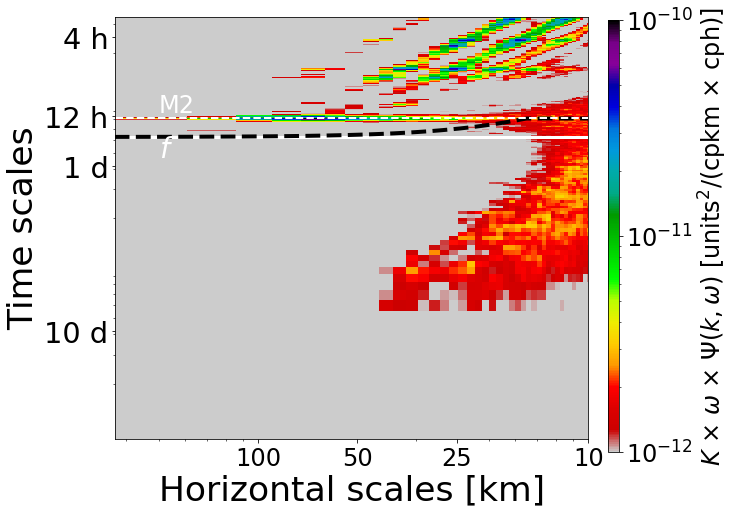

868 ASO


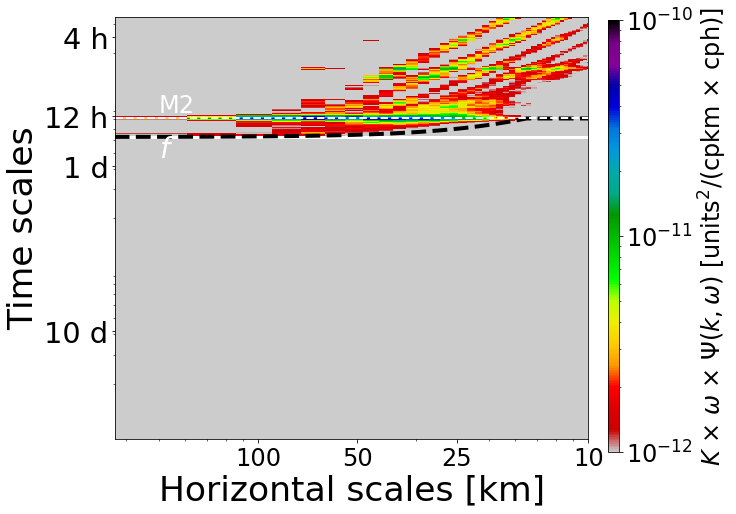

852 JFM


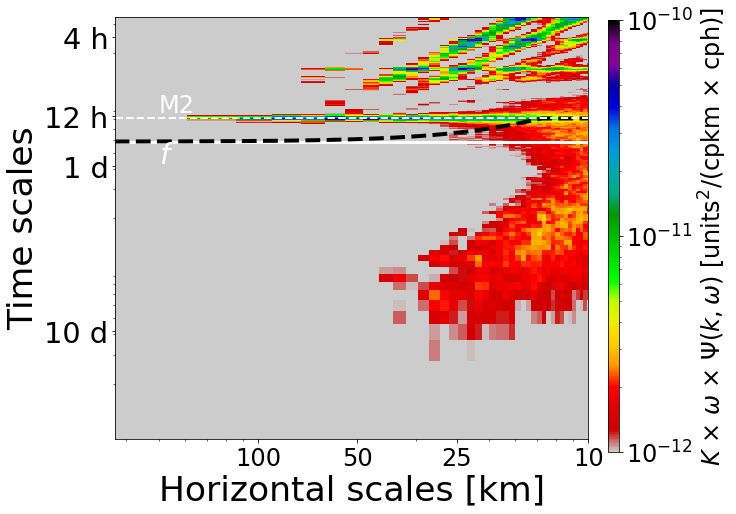

852 ASO


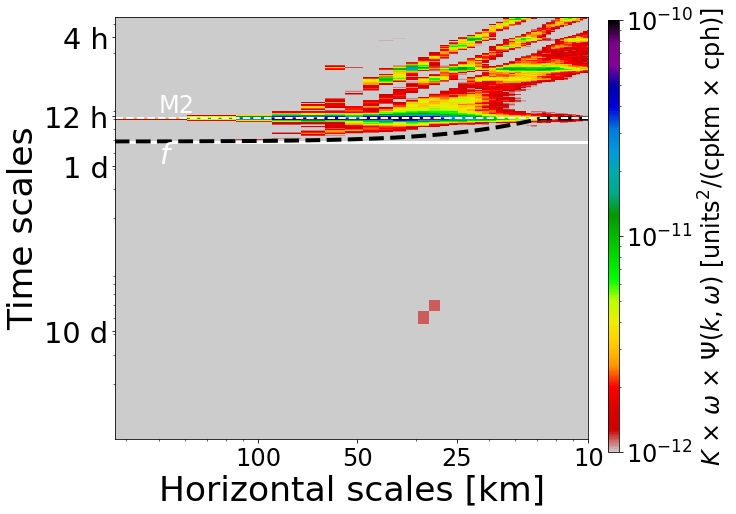

831 JFM


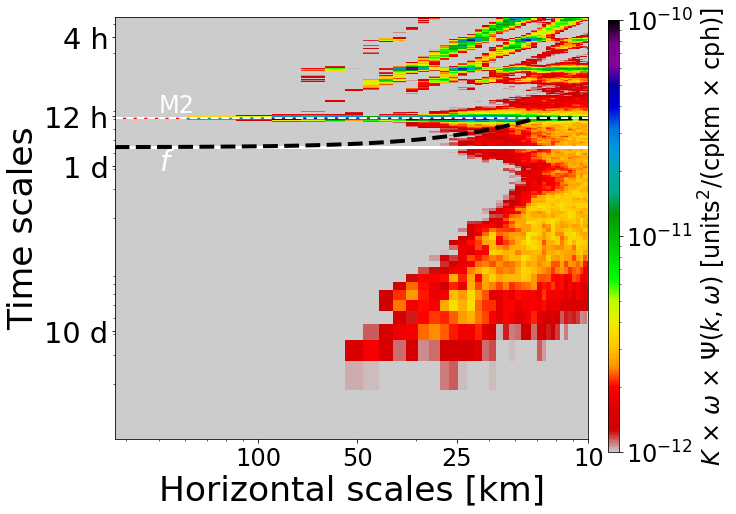

831 ASO


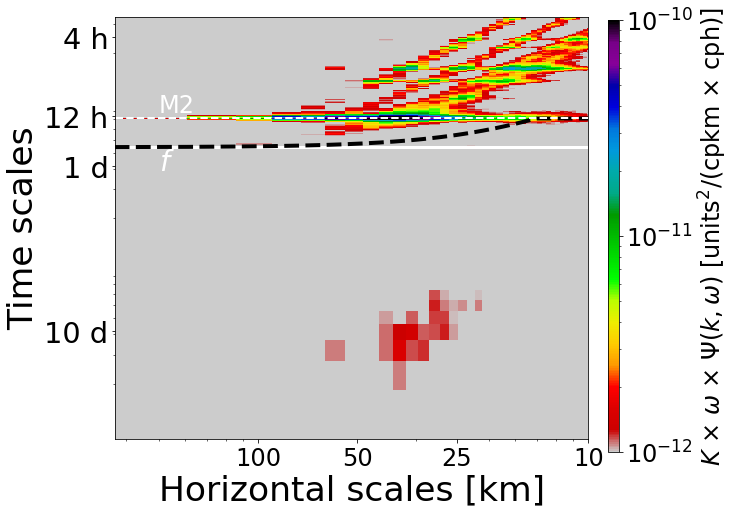

809 JFM


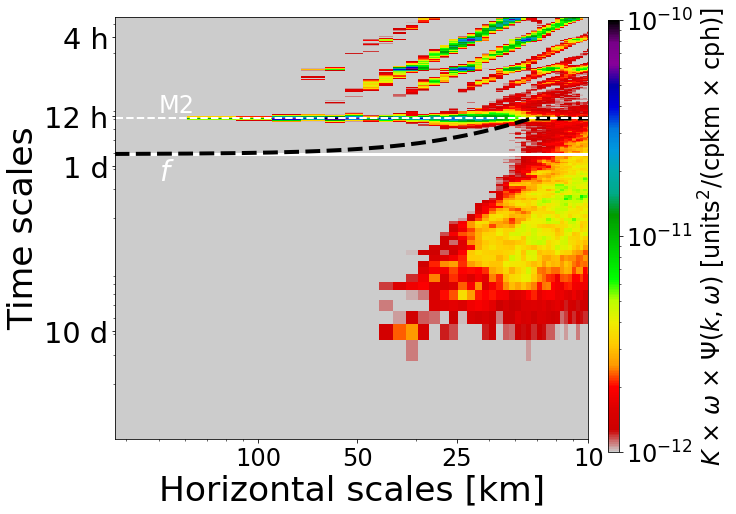

809 ASO


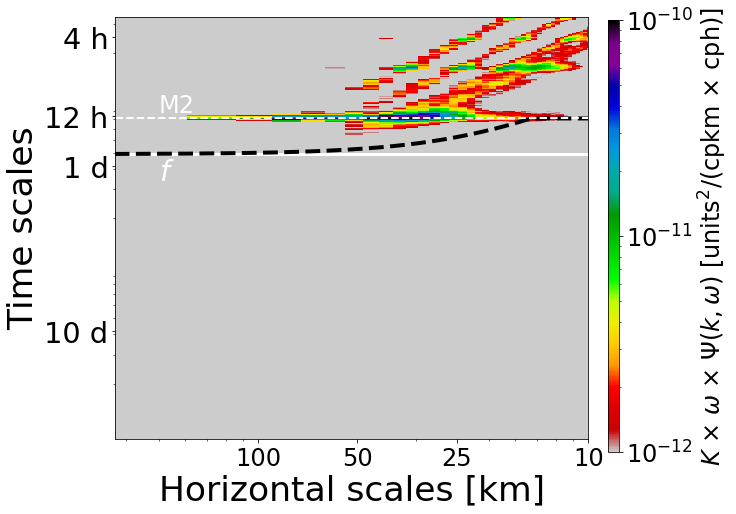

787 JFM


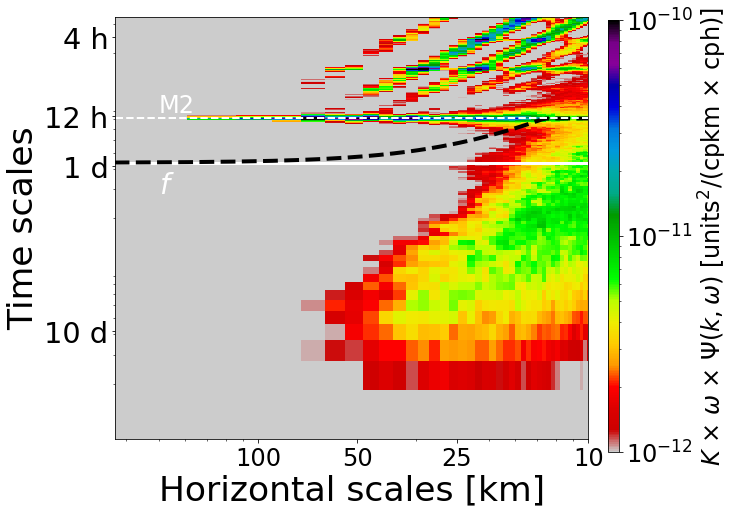

787 ASO


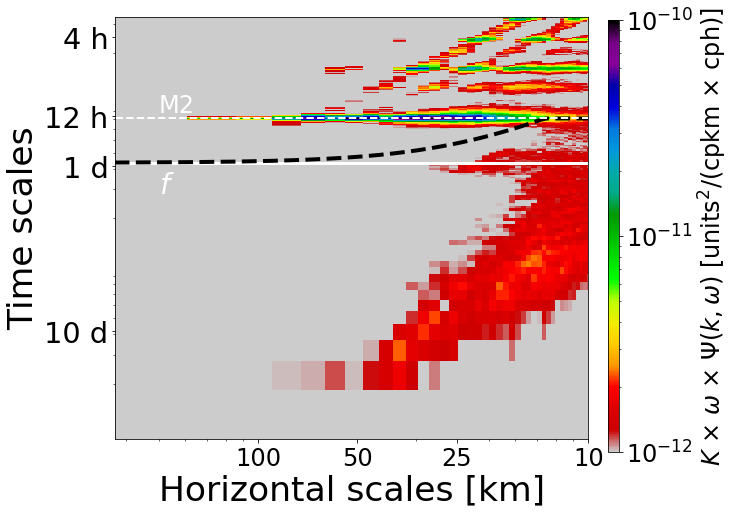

762 JFM


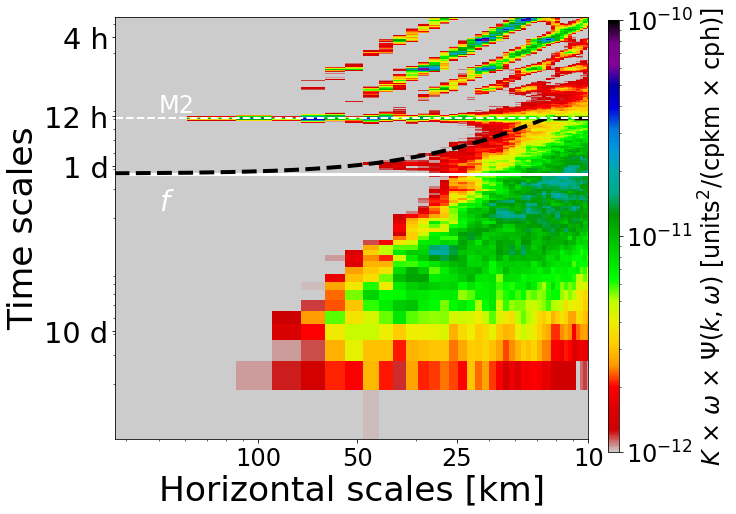

762 ASO


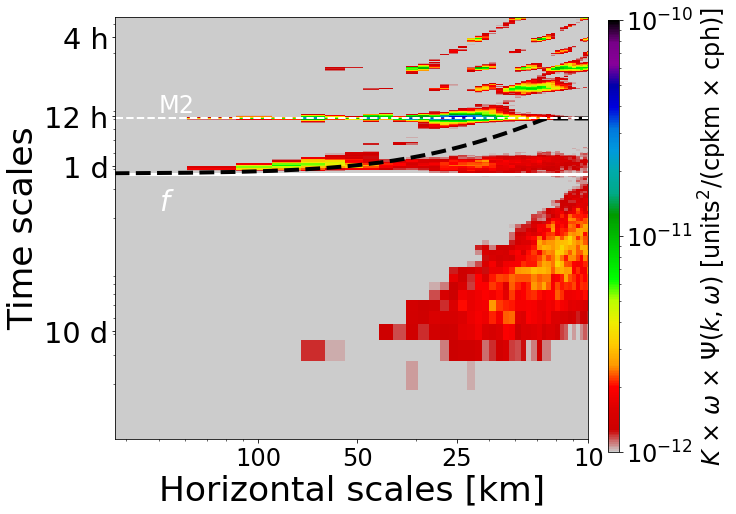

In [34]:
for id in ids_Cal:
    id_data = geodata_all.loc[id]
    #Nbv = id_data["Nbv_cph"]
    Nbv = id_data["Nbv_cph_2"]
    H = id_data["H"]/1000
    print(id,"JFM")
    plot_wk(prnt_folder,"JFM","RV",id,Nbv=Nbv,H=H,wk_only=True,log=False)
    print(id,"ASO")
    plot_wk(prnt_folder,"ASO","RV",id,Nbv=Nbv,H=H,wk_only=True,log=False)

### Gráficas BM/IGW para cada región

Se calcula $R(k) = \frac{BM(k)}{IGW(k)}$

In [31]:
# Gráficas
import matplotlib.pyplot as plt

def show_bm_igw(ids,vars,season,scales_km=(200,10),log=False):
    data_ = geodata_all.loc[ids]
    Nbv = data_["Nbv_cph_2"]
    H = data_["H"]/1000
    Rds = data_["Rd1"]
    print(Rds)

    nseasons = 1
    if type(season) is list:
        nseasons = len(season)
    else:
        season = [season]

    nplots = len(vars)
    fig,ax = plt.subplots(nplots,nseasons,figsize=(8*nseasons,4.5*len(vars)))
    ax = ax.flat[:]
    for season_,nseason in zip(season,range(nseasons)):
        plot_idxx = [nseasons*i+nseason for i in range(nplots)]
        for var,plot_idx in zip(vars,plot_idxx):
            print(var,plot_idx)
            ax_ = ax[plot_idx]
            plt.sca(ax_)
            plot_bm_igw(prnt_folder,season_,var,ids,scales_km=scales_km,Nbv=Nbv,H=H,ax=ax_,show=False,log=log)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.show()

#### California

868    20.221389
852    21.104625
831    25.479200
809    31.138500
787    33.780867
762    41.046100
Name: Rd1, dtype: float64
SSH 0
KE 2
DIV 4
RV 6
SSH 1
KE 3
DIV 5
RV 7


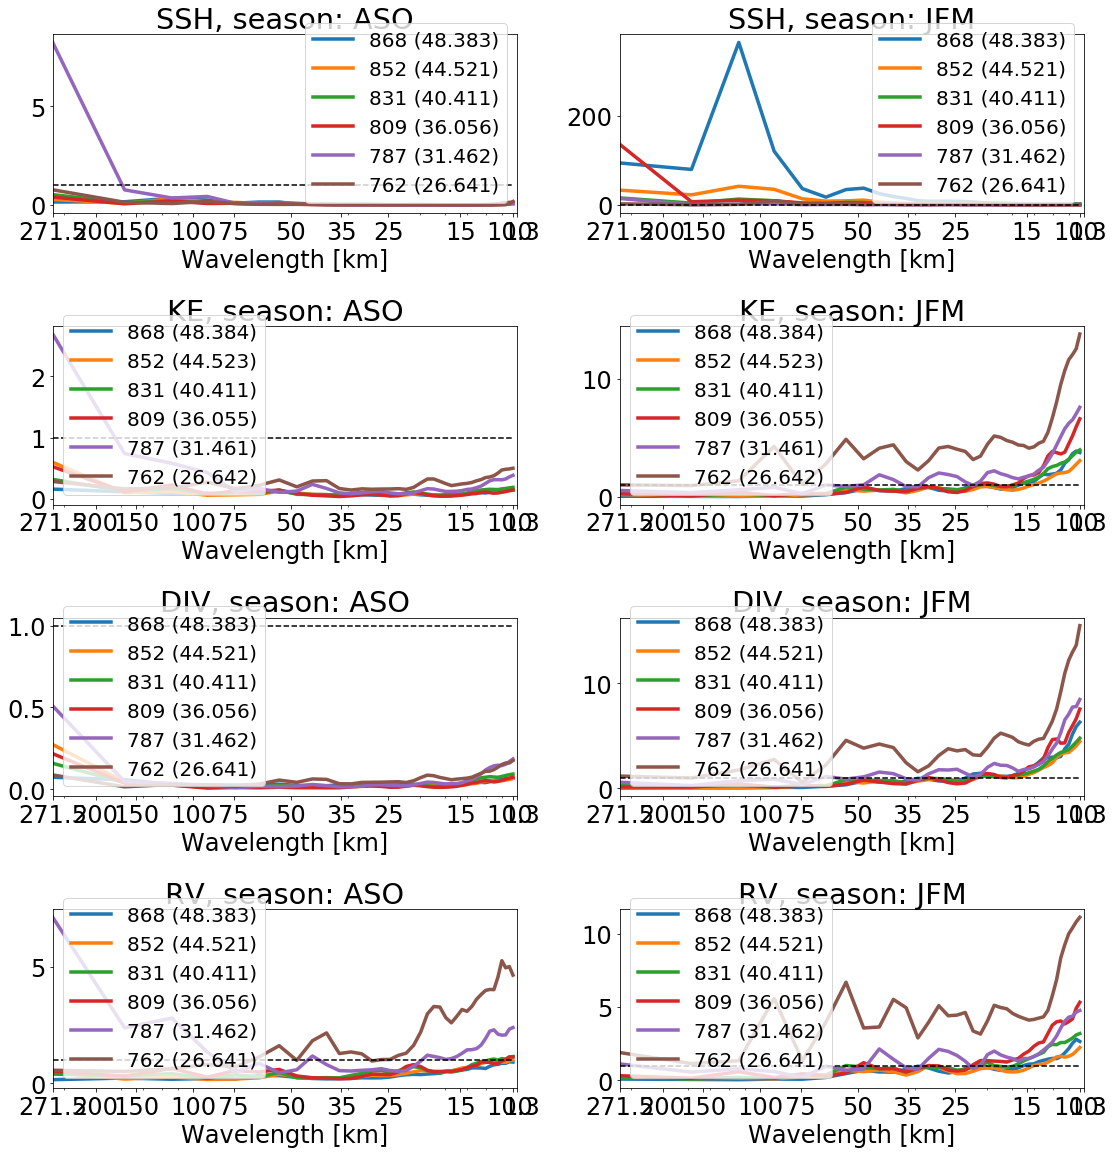

In [32]:
# California
show_bm_igw(ids_Cal,vars,['ASO','JFM'],scales_km=(310,10),log=False)
#show_bm_igw([762,787],vars,['ASO','JFM'],scales_km=(410,10))

#### Canarias

771    36.201900
750    40.876433
730    47.304967
709    61.639733
Name: Rd1, dtype: float64
SSH 0
KE 2
DIV 4
RV 6
SSH 1
KE 3
DIV 5
RV 7


/home/antonio/.conda/envs/llc/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


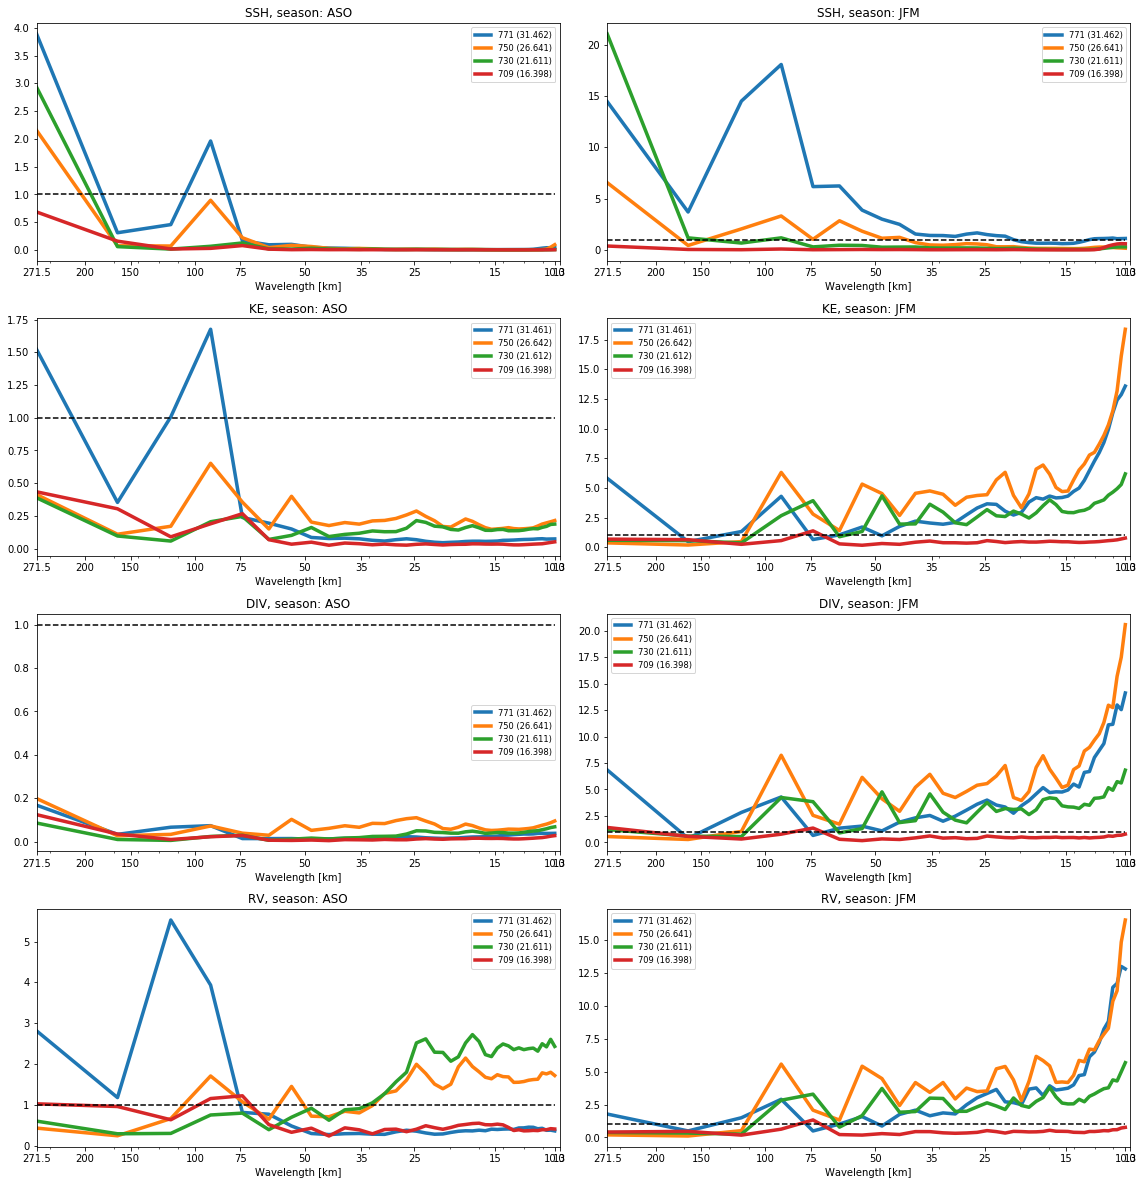

In [22]:
# Canarias
show_bm_igw(ids_Can,vars,['ASO','JFM'],scales_km=(310,10),log=False)

#### Peru

596    60.779033
572    46.628900
450    24.668067
Name: Rd1, dtype: float64
SSH 0
KE 2
DIV 4
RV 6
SSH 1
KE 3
DIV 5
RV 7


/home/antonio/.conda/envs/llc/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


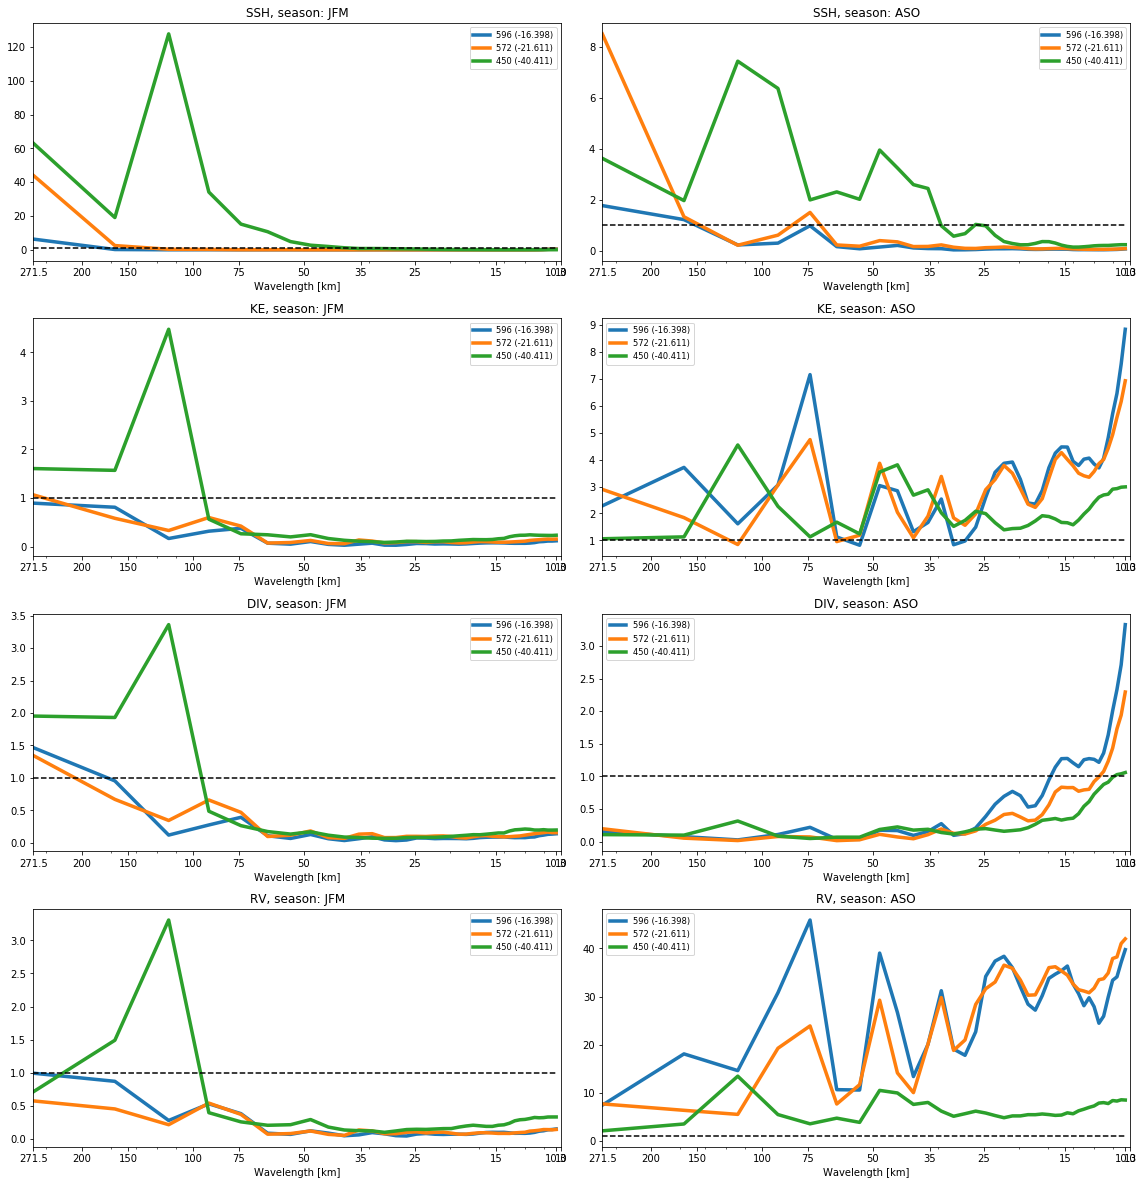

In [23]:
# Peru
#show_bm_igw(ids_Peru,vars,['JFM','ASO'],scales_km=(310,10))
show_bm_igw(ids_Peru,vars,['JFM','ASO'],scales_km=(500,10),log=False)

#### Benguela

602    90.987111
578    59.651100
533    37.492933
Name: Rd1, dtype: float64
SSH 0
KE 2
DIV 4
RV 6
SSH 1
KE 3
DIV 5
RV 7


/home/antonio/.conda/envs/llc/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


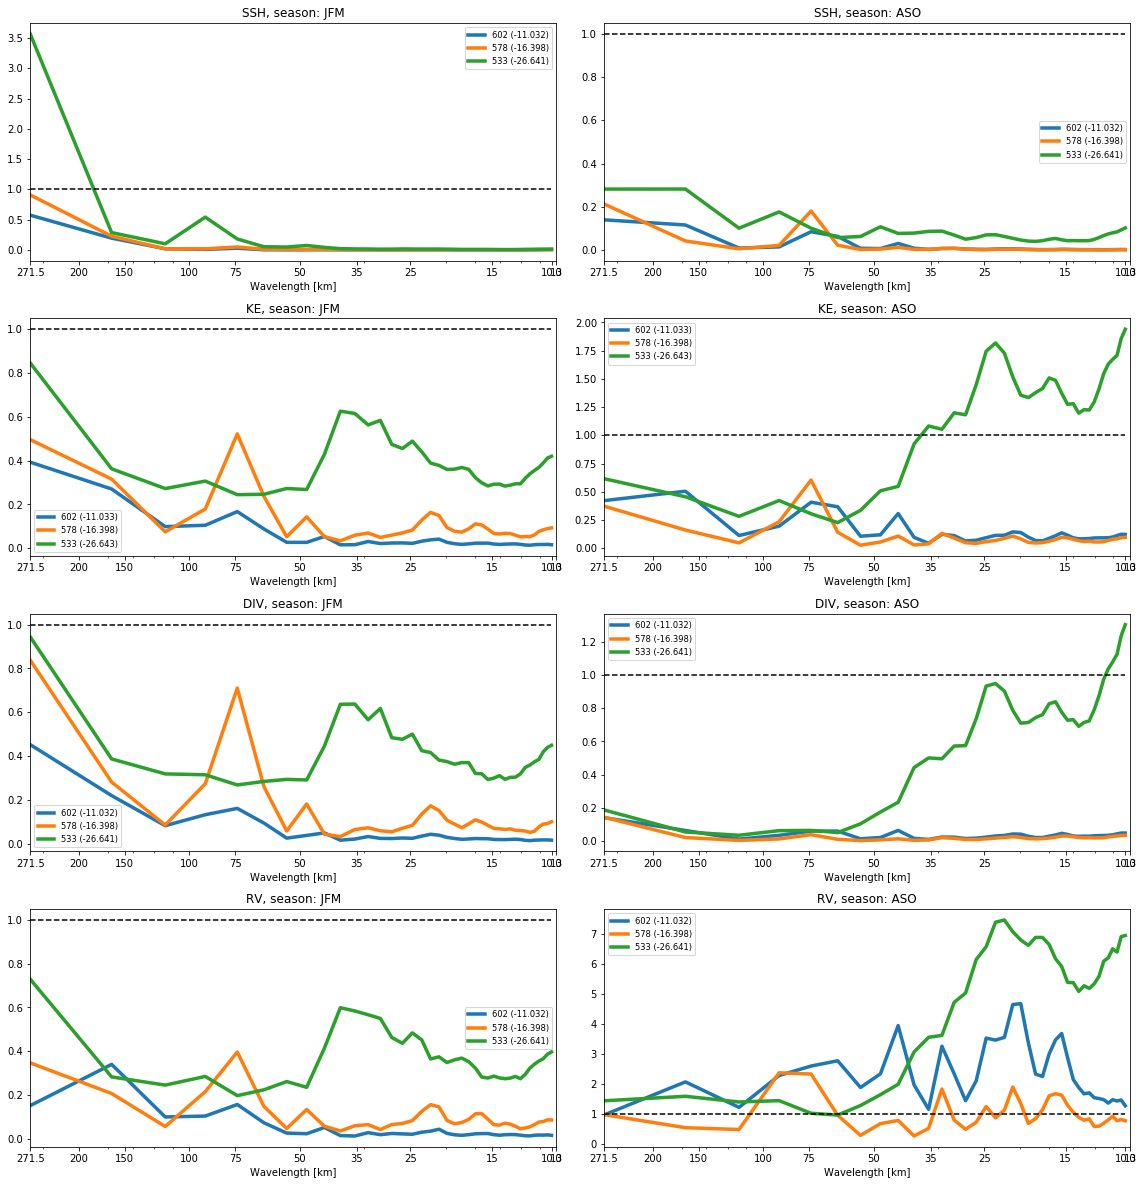

In [24]:
# Benguela
show_bm_igw(ids_Ben,vars,['JFM','ASO'],scales_km=(310,10))